## Introduction to GDAL & Utility Programs

### GDAL

Geospatial Data Abstraction Library https://www.gdal.org

Supports more than 100 **Raster Formats** (and also **Vector Formats**)

Tons of utility programs

https://gdal.org/programs/index.html

## Get data!

Let's get a **global** raster dataset, this means a dataset covering our whole planet.

So let's download it. Let's create two functions:

### Utility Functions

In ``download.py`` I created two simple functions:

<div class="alert alert-block alert-info"> 
<b>download(...)</b>:<br/>To download data from an url and display a <b>progress bar</b> (as geodata can be large). Skip already downladed files.
</div>

<div class="alert alert-block alert-info"> 
<b>unzip(...)</b>:<br/> To unzip a file. It skips already unzipped files. If we execute the notebooks again, it will not unzip again.
</div>

I'm not going into implementation details here, if you are interested in the functions, check them out in download.py
It uses the base Python modules urllib.request and zipfile.


In [ ]:
from download import download,unzip

### Data Directory "geodata"

First we create a new directory "geodata" if it doesn't exist yet.

In [ ]:
import os

if not os.path.exists("geodata"):
    os.mkdir("geodata")

### About the Naturalearth Dataset

The Natural Earth dataset is a free and open-source vector and raster map data package that provides basic geographic information for the entire world. The dataset was created by Nathaniel Vaughn Kelso and Tom Patterson, and is maintained by a community of contributors.

The Natural Earth dataset includes several layers of geographic data, including:

* Physical features: such as land, ocean, and coastline boundaries, as well as major rivers, lakes, and mountains.
* Cultural features: such as country and state boundaries, populated places, roads, and railways.
* Geographical features: such as time zones, land cover, and elevation.

The data is available in various formats, including shapefiles, GeoJSON, and raster files, and is designed to be easily used with a variety of GIS software and applications.

The Natural Earth dataset is widely used in cartography, geography, and other fields that require accurate and up-to-date geographic information. It is also used as a base layer for a range of mapping applications, including web mapping, data visualization, and geographic analysis.


More info: https://www.naturalearthdata.com/

We are downloading a raster dataset: more info/overview here: https://www.naturalearthdata.com/downloads/10m-raster-data/

(342 MB)


In [ ]:
# Let's download the data:
url ="https://naciscdn.org/naturalearth/10m/raster/NE2_HR_LC_SR_W.zip"
#backup_url = "https://www.geopython.xyz/geodata/naturalearth/NE2_HR_LC_SR_W.zip"  # use this if url above doesn't work anymore

download(url, "geodata/ne_raster.zip")
print("unzipping...")
unzip("geodata/ne_raster.zip", "geodata")
print("done")

### Raster Information

Using the tool "gdalinfo" we can get some information about raster data. This is one of many utility programs that come with GDAL.
(https://gdal.org/programs/index.html)

In Jupyter Notebooks we can call a programm using ! as prefix. For example (under Windows) you could call `!calc.exe` and the calculator is opened. (don't do that!)

You can also call the utilities from the anaconda prompt (don't forget to activate our environment!)

So let's call `gdalinfo` with our newly downloaded dataset:

In [ ]:
!gdalinfo geodata/NE2_HR_LC_SR_W.tif

## Open Dataset in QGIS

You can drag and drop the raster file NE2_HR_LC_SR_W.tif into QGIS. You will notice a few things:


* If you move your mouse around you see the geographic coordinate on the bottom bar.
* You also see **EPSG:4326**, which represents the Coordinate Reference System (CRS) of the image, which is WGS84. More about that later.
* With your mouse wheel you can zoom in/out. Zoom in until you see pixel blocks (max resolution)



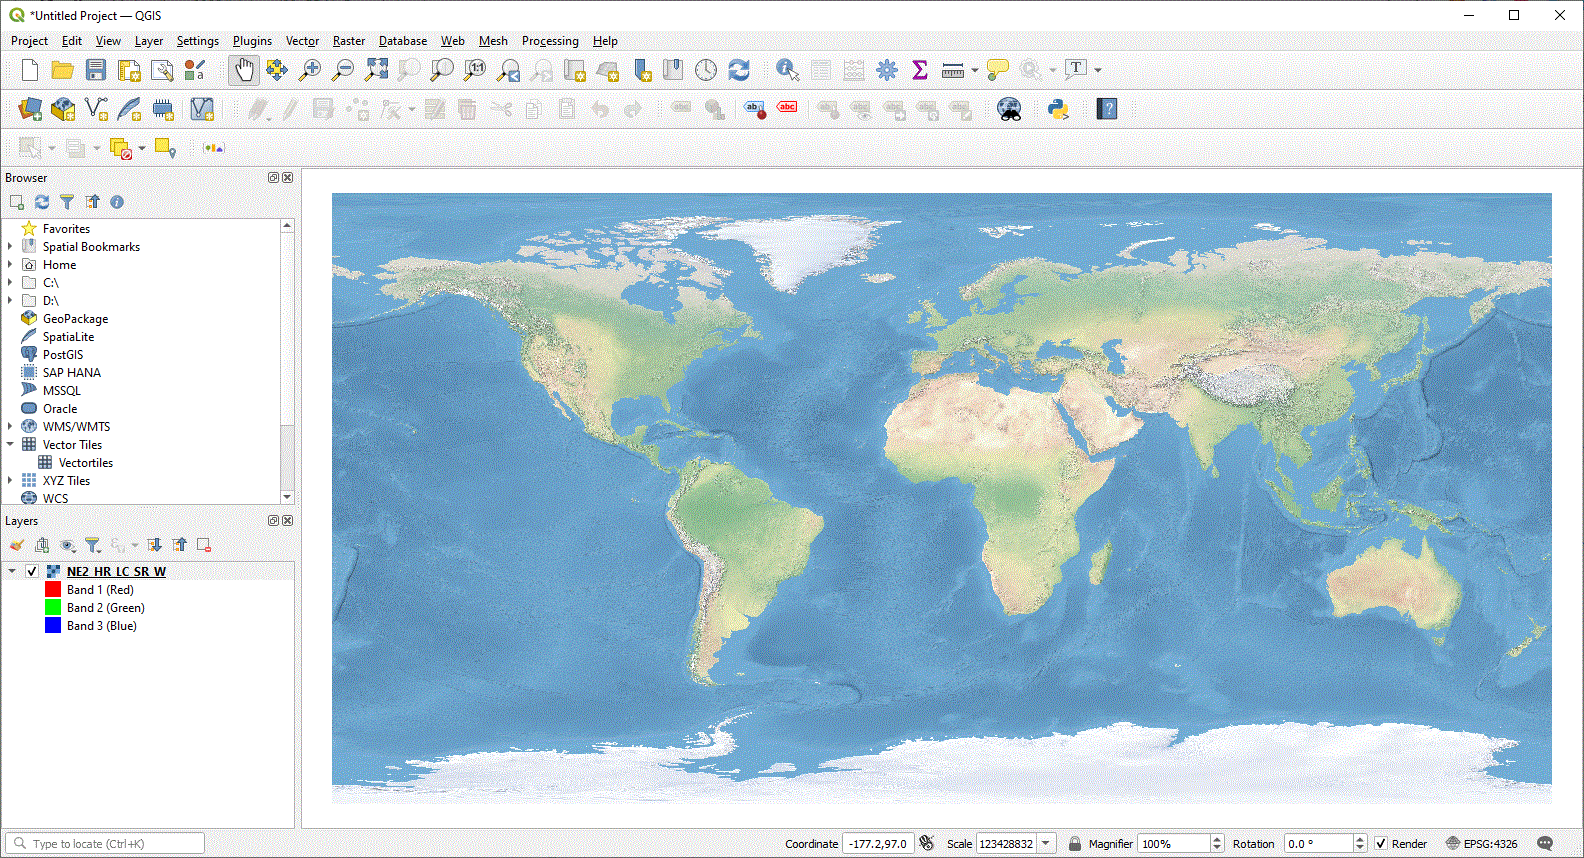</img>



## Georeferencing

* Converting pixel coordinates to Geo-coordinates
* Converting Geo-coordinates to pixel coordinates

For this we need additional information!

### Variant 1: Using Worldfiles

Georeferencing Raster Data using "World files".<br/>
The specification was introduced by Esri.

* TIFF -> .tfw  
* PNG -> .pgw 
* JPEG -> .jgw  
* GIF   -> .gfw

The world file is an ASCII Text file with the following layout:

* Line 1: A: pixel size in the x-direction in map units/pixel
* Line 2: D: rotation about y-axis  (-> most cases 0)
* Line 3: B: rotation about x-axis  (-> most cases 0)
* Line 4: E: pixel size in the y-direction in map units, almost always negative
* Line 5: C: x-coordinate of the center of the upper left pixel
* Line 6: F: y-coordinate of the center of the upper left pixel


Our file contains a ".tfw". You can look at it now.



### Variant 2: Georeferenciation in the Image Header

Many raster formats have headers for custom data. TIFF Files can have a "Geo" Header containing additiona information such as georeferenciation. Those files are also called GeoTiff.


#### Using 'gdal_translate'

Creating a new file in a new format (e.g. GeoTiff)

     gdal_translate -of GTiff -co COMPRESS=JPEG -a_srs EPSG:4326 -a_ullr -180 90 180 -90 geodata/NE2_HR_LC_SR_W.tif geodata/world.tif
     
However this is not necessary as the file is already a GeoTiff. The ".tfw" is not really necessary in this case, but still provided by Natural Earth.


### Variant 3: Georeferenciation in aux.xml Files

For formats that don't have a header GDAL creates aux.xml files containing georeferencing info (CRS and affine transformation)




## Changing Image Size


`gdal_translate` can also be used to change the image dimensions (with and height).

The parameter is -outsize and you can give the dimensions in percent or pixels. If one of them is 0, the correct asepect ratio is calculated automatically.

Examples:

    gdal_translate -outsize 2048 1024 geodata/NE2_HR_LC_SR_W.tif geodata/world_small.tif
    gdal_translate -outsize 5000 0 geodata/NE2_HR_LC_SR_W.tif geodata/world_medium.tif
    gdal_translate -outsize 50% 50% geodata/NE2_HR_LC_SR_W.tif geodata/world_half.tif


Let's try one out:


In [ ]:
!gdal_translate -outsize 2048 1024 geodata/NE2_HR_LC_SR_W.tif geodata/world_small.tif

In [ ]:
!gdalinfo geodata/world_small.tif

When we convert to a format without Geo-Header, a aux.xml file is created.

In [ ]:
!gdal_translate -of JPEG -outsize 512 256 geodata/NE2_HR_LC_SR_W.tif geodata/world_small.jpg

Because it is a normal JPG image, we can directly display it in Jupyter:

In [ ]:
from IPython.display import Image

Image(filename='geodata/world_small.jpg') 

### Working with Larger Datasets: Blue Marble Dataset

Some image formats have restrictions in size. JPEG for example can have a maximal dimension of 65535x65535.
The blue marble dataset by nasa (https://visibleearth.nasa.gov/collection/1484/blue-marble ) is yet another global dataset.

The highest resolution available is 86400 x 43200. Because this is rather large the dataset comes in 8 tiles.

We have to download 8 different image-tiles A1,A2,B1,B2,C1,C2,D1, and D2. The tile layout is the following:

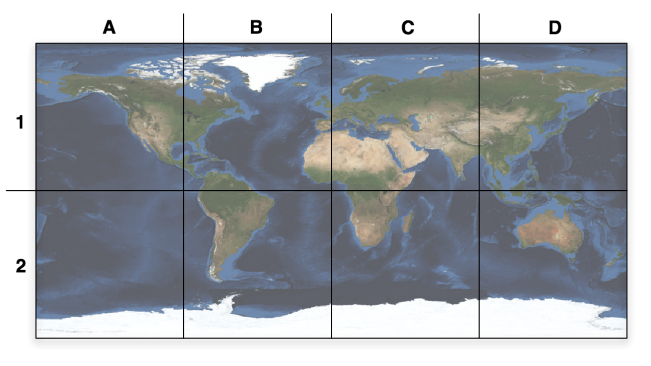</img>



The tiles can be found here: We will get the data from:
https://visibleearth.nasa.gov/collection/1484/blue-marble?page=1

July:
https://visibleearth.nasa.gov/images/73751/july-blue-marble-next-generation-w-topography-and-bathymetry/73765l



Direct download links are:


July:
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600.A1.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600.A2.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600.B1.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600.B2.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600.C1.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600.C2.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600.D1.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600.D2.png

December:
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x21600.A1.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x21600.A2.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x21600.B1.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x21600.B2.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x21600.C1.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x21600.C2.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x21600.D1.png
* https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x21600.D2.png



Let's download the data (**this will take a while**, be patient...)

In [ ]:
dest_dir = "geodata/bluemarble/"

if not os.path.exists(dest_dir):
    os.mkdir(dest_dir)

base = "https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73751/world.topo.bathy.200407.3x21600x21600."
#base = "https://www.geopython.xyz/geodata/bluemarble/july/world.topo.bathy.200407.3x21600x21600."  # use this incase URL above doesn't work

urls = [base + "A1.png", base + "A2.png", base + "B1.png", base + "B2.png",
        base + "C1.png", base + "C2.png", base + "D1.png", base + "D2.png"]

for url in urls:
    download(url, dest_dir + os.path.basename(url), False)

### Add Georeferenciation

The images are not georeferenced. We can either add it manually by creating world files or we can convert them to GeoTiff and specify the extent and projection. Instead of creating a new file we could also use the `gdaledit.py` tool. However, PNG is not a great format for geodata, it is better to use GeoTiff.

This conversion takes a couple of minutes.

In [ ]:
!gdal_translate -of GTiff -co TILED=YES -a_srs WGS84 -a_ullr -180 90 -90 0 geodata/bluemarble/world.topo.bathy.200407.3x21600x21600.A1.png geodata/bluemarble/A1.tif
!gdal_translate -of GTiff -co TILED=YES -a_srs WGS84 -a_ullr -90 90 0 0 geodata/bluemarble/world.topo.bathy.200407.3x21600x21600.B1.png geodata/bluemarble/B1.tif
!gdal_translate -of GTiff -co TILED=YES -a_srs WGS84 -a_ullr 0 90 90 0 geodata/bluemarble/world.topo.bathy.200407.3x21600x21600.C1.png geodata/bluemarble/C1.tif
!gdal_translate -of GTiff -co TILED=YES -a_srs WGS84 -a_ullr 90 90 180 0 geodata/bluemarble/world.topo.bathy.200407.3x21600x21600.D1.png geodata/bluemarble/D1.tif
!gdal_translate -of GTiff -co TILED=YES -a_srs WGS84 -a_ullr -180 0 -90 -90N geodata/bluemarble/world.topo.bathy.200407.3x21600x21600.A2.png geodata/bluemarble/A2.tif
!gdal_translate -of GTiff -co TILED=YES -a_srs WGS84 -a_ullr -90 0 0 -90 geodata/bluemarble/world.topo.bathy.200407.3x21600x21600.B2.png geodata/bluemarble/B2.tif
!gdal_translate -of GTiff -co TILED=YES -a_srs WGS84 -a_ullr 0 0 90 -90 geodata/bluemarble/world.topo.bathy.200407.3x21600x21600.C2.png geodata/bluemarble/C2.tif
!gdal_translate -of GTiff -co TILED=YES -a_srs WGS84 -a_ullr 90 0 180 -90 geodata/bluemarble/world.topo.bathy.200407.3x21600x21600.D2.png geodata/bluemarble/D2.tif

### Build a VRT

  
The GDAL Virtual Format (VRT) is a easy way to create a new dataset out of tiles. It is basically a Text (XML) file but the vrt-File can be treated as if it was a single raster file.

    

In [ ]:
!gdalbuildvrt geodata/bluemarble.vrt geodata/bluemarble/A1.tif geodata/bluemarble/A2.tif geodata/bluemarble/B1.tif geodata/bluemarble/B2.tif geodata/bluemarble/C1.tif geodata/bluemarble/C2.tif geodata/bluemarble/D1.tif geodata/bluemarble/D2.tif

In [ ]:
!gdalinfo geodata/bluemarble.vrt

### Add Overviews

If you try to open this file in QGIS - it is way to slow. 

We need to create multiple resolutions of this file, called **overlays** (also called **pyramid**).
This can be done using the `gdaladdo` tool.


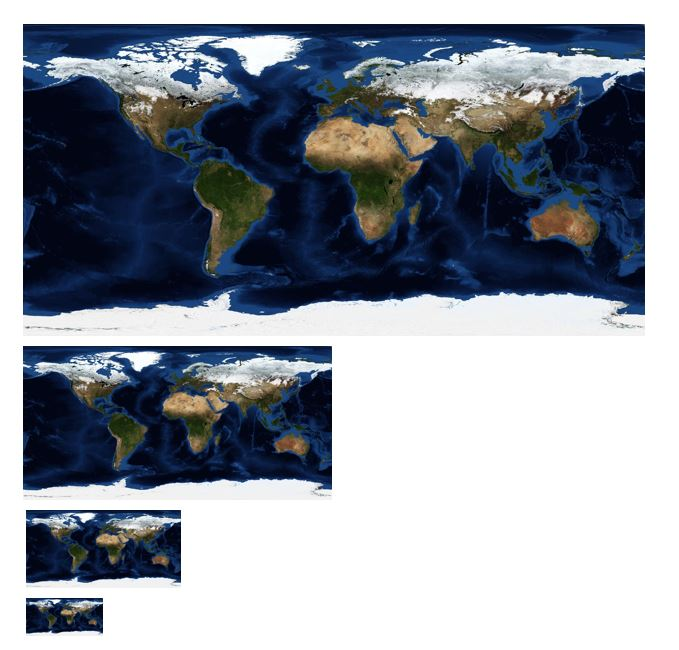</img>



the -r parameter can be used to specify the resampling method. It can be:

nearest, average, rms, bilinear, gauss, cubic, cubicspline, lanczos, average_magphase, mode

After the filename we have to specify levels as a power of 2, for example 2 4 8 16 32

This will take a really long time to process. If you try doing this with a very large dataset (>1 TB) it may take days up to weeks. In this case it is also recommended to increase memory and enable parallel processing. This can be done using this config flag:



`--config GDAL_NUM_THREADS ALL_CPUS`     (or integer value, if you want to specify the number of cpus)

`--config GDAL_CACHEMAX 8000`            (cache in MB, do as high as possible, depending your RAM)               

In [ ]:
!gdaladdo -r average geodata/bluemarble.vrt 2 4 8 16 32

### Convert

We can also convert the vrt to any other format, for example in a highly compressed JP2OpenJPEG file. (wavelet based compression)

This takes again a while to process

In [ ]:
!gdal_translate -of JP2OpenJPEG geodata/bluemarble.vrt geodata/bluemarble.jp2

Of course we can resize this larger image again to a smaller one:

In [ ]:
!gdal_translate -outsize 2048 1024 geodata/bluemarble.vrt geodata/bluemarble_small.jpg

### Extracting Raster Data

If we want to extract a part of a (large) raster file, we can also use the `gdal_translate` tool. 

Let's extract Switzerland from the bluemarble dataset:

The bounding box of Switzerland is  (5.96,45.82)-(10.49, 47.81)

we can use the `-projwin` flag to extract it. Please note that the origin of the extract is top left.

In [ ]:
!gdal_translate -of GTiff -co TILED=YES -projwin 5.96 47.81 10.49 45.82 geodata/bluemarble.vrt geodata/switzerland.tif

In [ ]:
!gdalinfo geodata/bluemarble.vrt

## Image Reprojection

When we look at the Switzerland dataset we see a large distortion. The original dataset is in WGS84 / equirectangular projection. We will learn more about projections later. 

Let's reproject the image to local swiss coordinates, they are specified in EPSG:2056. The original dataset is WGS84 and defined in EPSG:4326.

EPSG stands for **European Petroleum Survey Group** and they created the EPSG registry containing spatial reference systems and more.

Using the GDAL tool `gdalwarp` we can reproject from one spatial reference system to another. 

In [ ]:
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:2056 geodata/switzerland.tif geodata/switzerland_lv95.tif

We can also reproject to the **Web Mercator** projection used in web maps such as Google Maps, OpenStreetMap etc. The EPSG code is 3857.

In [ ]:
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 geodata/switzerland.tif geodata/switzerland_merc.tif

## Working with Elevation Data

So far we only looked at raster files containing RGB images with 8 bit (1 Byte) per band. There is basically no limitation what datatype a band is and how many there are. We are looking at Elevation data, typically containing floating point data for each raster point, representing elevation.


We will download the SRTM dataset.

SRTM Elevation dataset can be obtained at:

* https://srtm.csi.cgiar.org/srtmdata


In [ ]:
# download and extract SRTM elevation data over Switzerland:

url = "https://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_38_03.zip"
#backup_url = "https://www.geopython.xyz/geodata/srtm/srtm_38_03.zip"

# Download and unzip url:
download(url, "geodata/" + os.path.basename(url), False)
unzip(f"geodata/{os.path.basename(url)}", "geodata")

### Create a hillshade

Using gdaldem we can create a hillshade:

In [ ]:
!gdaldem hillshade geodata/srtm_38_03.tif geodata/srtm_38_03_hillshade.png

In [ ]:
# Create a color ramp file:
#
# Elevation RGB color

color_text_file = """0 110 220 110
500 240 250 160 
1500 230 220 170 
2000 220 220 220
2500 250 250 250"""

file = open("geodata/color.txt", "w")
file.write(color_text_file)
file.close()

In [ ]:
!gdaldem color-relief geodata/srtm_38_03.tif geodata/color.txt geodata/srtm_38_03_color_relief_map.png

### More Utils

There are tons of more gdal utility programs. We're not looking at all now. You can do that at https://gdal.org/programs/index.html

Also, many gdal programs can be executed from QGIS, as QGIS also uses GDAL.

From now on we do most things in Python as we have more control over things.